In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm import tqdm

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Load in data**

In [2]:
all_cols = [
    "gcs_mn_all", "gcs_mn_se_all", "tot_asmt_all",
    "gcs_mn_asn", "gcs_mn_se_asn", "tot_asmt_asn",
    "gcs_mn_blk", "gcs_mn_se_blk", "tot_asmt_blk",
    "gcs_mn_ecd", "gcs_mn_se_ecd", "tot_asmt_ecd",
    "gcs_mn_fem", "gcs_mn_se_fem", "tot_asmt_fem",
    "gcs_mn_hsp", "gcs_mn_se_hsp", "tot_asmt_hsp",
    "gcs_mn_mal", "gcs_mn_se_mal", "tot_asmt_mal",
    "gcs_mn_mfg", "gcs_mn_se_mfg", "tot_asmt_mfg",
    "gcs_mn_nam", "gcs_mn_se_nam", "tot_asmt_nam",
    "gcs_mn_nec", "gcs_mn_se_nec", "tot_asmt_nec",
    "gcs_mn_neg", "gcs_mn_se_neg", "tot_asmt_neg",
    "gcs_mn_wag", "gcs_mn_se_wag", "tot_asmt_wag",
    "gcs_mn_wbg", "gcs_mn_se_wbg", "tot_asmt_wbg",
    "gcs_mn_whg", "gcs_mn_se_whg", "tot_asmt_whg",
    "gcs_mn_wht", "gcs_mn_se_wht", "tot_asmt_wht",
    "gcs_mn_wng", "gcs_mn_se_wng", "tot_asmt_wng",
]

race_cols = [
    "gcs_mn_all", "gcs_mn_se_all", "tot_asmt_all",
    "gcs_mn_asn", "gcs_mn_se_asn", "tot_asmt_asn",
    "gcs_mn_blk", "gcs_mn_se_blk", "tot_asmt_blk",
    "gcs_mn_hsp", "gcs_mn_se_hsp", "tot_asmt_hsp",
    "gcs_mn_nam", "gcs_mn_se_nam", "tot_asmt_nam",
]

gender_cols = [
    "gcs_mn_all", "gcs_mn_se_all", "tot_asmt_all",
    "gcs_mn_fem", "gcs_mn_se_fem", "tot_asmt_fem",
    "gcs_mn_mal", "gcs_mn_se_mal", "tot_asmt_mal",
]

In [ ]:
if not os.path.exists("./data/data.db"):
    os.system("python build_db.py")

conn = sqlite3.connect("./data/data.db")
c = conn.cursor()


COLS_EXCLUDE = set([
    "StateAbbr",
    "StateDesc",
    "CountyName",
    "CountyFIPS",
    "TractFIPS",
    "fips",
    "stateabb",
    "sedaadmin",
    "sedaadminname",
    "TRACT",
    "COUNT"
])

c.execute(f"""
WITH seda_tracts AS (
    SELECT *
    FROM seda s
    JOIN nces n
    ON s.sedaadmin = n.LEAID
    WHERE s.year = 2019
)

, food_atlas_tracts AS (
    SELECT *
    FROM food f
    JOIN seda_tracts st
    ON st.TRACT = f.CensusTract
)

, cdc_tracts AS (
    SELECT *
    FROM cdc c
    JOIN food_atlas_tracts ft
    ON ft.TRACT = c.TractFIPS
)

SELECT *
FROM cdc_tracts;
""")

rows = c.fetchall()
print(len(rows))
columns = [col[0] for col in c.description]

## Write the rows manually into a CSV file without pandas
with open("data/full_joined_table.csv", "w") as f:
    to_exclude = set()
    # race_cols = []
    # for i, col in enumerate(columns):
    #     if (col.startswith("gcs") or col.startswith("tot")) and col not in race_cols:
    #         to_exclude.add(i)

    f.write(",".join(columns) + "\n")
    for row in tqdm(rows):
        f.write(",".join([str(x) for i, x in enumerate(row) if i not in to_exclude]) + "\n")


995894


100%|██████████| 995894/995894 [00:15<00:00, 62604.23it/s]


In [ ]:
df = pd.read_csv("data/full_joined_table.csv")
# df

KeyboardInterrupt: 

LEN BEFORE DROPPING NULL VALUES:  995894
LEN AFTER DROPPING NULL VALUES:  106228


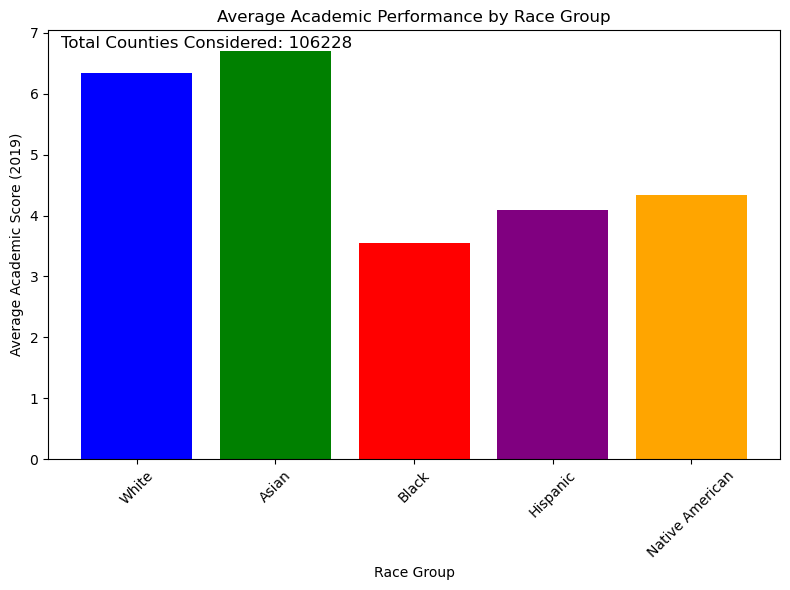

In [18]:
# ANALYSIS QUESTION 1: 
# Is there a statistically significant difference in the academic
# performance across race groups? 

# Load the dataset
df = pd.read_csv("data/full_joined_table.csv")

# Select relevant columns and check for null values
print("LEN BEFORE DROPPING NULL VALUES: ", len(df))
df = df.dropna(subset=['gcs_mn_wht', 'gcs_mn_asn', 'gcs_mn_blk', 'gcs_mn_hsp', 'gcs_mn_nam'])
print("LEN AFTER DROPPING NULL VALUES: ", len(df))

# Calculate the average score for each group
avg_scores = {
    'White': df['gcs_mn_wht'].mean(),
    'Asian': df['gcs_mn_asn'].mean(),
    'Black': df['gcs_mn_blk'].mean(),
    'Hispanic': df['gcs_mn_hsp'].mean(),
    'Native American': df['gcs_mn_nam'].mean()
}

# Convert the dictionary to a DataFrame for easier plotting
score_df = pd.DataFrame(list(avg_scores.items()), columns=['Race Group', 'Average Score'])

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(score_df['Race Group'], score_df['Average Score'], color=['blue', 'green', 'red', 'purple', 'orange'])

# Add total county label on the graph
total_counties = len(df)
plt.text(0.5, max(score_df['Average Score']), f'Total Counties Considered: {total_counties}', 
         ha='center', va='bottom', fontsize=12, color='black')

# Add labels and title
plt.ylabel('Average Academic Score (2019)')
plt.xlabel('Race Group')
plt.title('Average Academic Performance by Race Group')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

gcs_mn_wht: mean=6.345, variance=6.345, std=1.795, min=0.9598806306129998, max=11.51715628263119
gcs_mn_asn: mean=6.708, variance=6.708, std=2.230, min=0.7786645641197613, max=12.96298515058919
gcs_mn_blk: mean=3.554, variance=3.554, std=1.733, min=-1.446894860298376, max=8.846638220644524
gcs_mn_hsp: mean=4.095, variance=4.095, std=1.669, min=-0.2975795100590959, max=8.804516790697118
gcs_mn_nam: mean=4.345, variance=4.345, std=1.966, min=-1.268578397922373, max=10.22937591067606
LEN BEFORE DROPPING NULL VALUES:  106228
LEN AFTER DROPPING NULL VALUES:  106228

=== Paired T-Test Results (White vs Others) ===
T-test between White vs Asian:
  t-statistic = -41.321, p-value = 0.0000e+00
  ➤ Statistically significant difference between White vs Asian.
----------------------------------------
T-test between White vs Black:
  t-statistic = 364.736, p-value = 0.0000e+00
  ➤ Statistically significant difference between White vs Black.
----------------------------------------
T-test between Whi

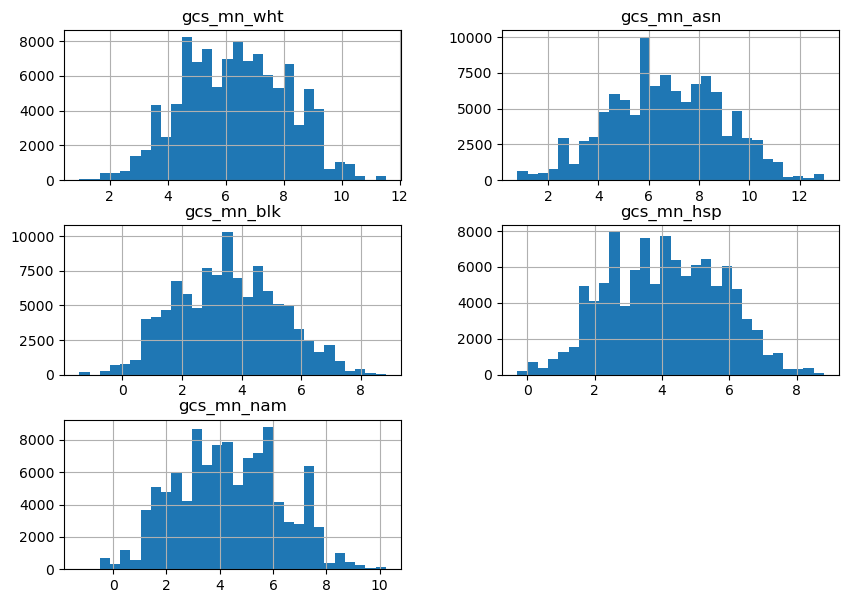

In [ ]:
# Q1 Statistical Analysis: Perform pairwise 2 sample t-tests between race groups
group_labels = ['White', 'Asian', 'Black', 'Hispanic', 'Native American']
group_cols = ['gcs_mn_wht', 'gcs_mn_asn', 'gcs_mn_blk', 'gcs_mn_hsp', 'gcs_mn_nam']

# Sanity check: print column stats before t-tests
for col in group_cols:
    print(f"{col}: mean={df[col].mean():.3f}, variance={df[col].mean():.3f}, std={df[col].std():.3f}, min={df[col].min()}, max={df[col].max()}")

print("LEN BEFORE DROPPING NULL VALUES: ", len(df))
# df = df.dropna(subset=['gcs_mn_wht', 'gcs_mn_asn', 'gcs_mn_blk', 'gcs_mn_hsp', 'gcs_mn_nam'])

import scipy.stats as stats

# Define the specific comparisons you care about
comparisons = [
    ('White vs Asian', 'gcs_mn_wht', 'gcs_mn_asn'),
    ('White vs Black', 'gcs_mn_wht', 'gcs_mn_blk'),
    ('White vs Hispanic', 'gcs_mn_wht', 'gcs_mn_hsp'),
    ('White vs Native American', 'gcs_mn_wht', 'gcs_mn_nam'),
]

# Drop any rows with missing data in the relevant columns
relevant_cols = list(set(col for _, col1, col2 in comparisons for col in (col1, col2)))
df = df.dropna(subset=relevant_cols)
print("LEN AFTER DROPPING NULL VALUES: ", len(df))

# Function to run only selected paired t-tests
def ttest_pairwise(df, comparisons):
    for label, col1, col2 in comparisons:
        t_stat, p_value = stats.ttest_ind(df[col1], df[col2], equal_var=False)
        print(f"T-test between {label}:")
        print(f"  t-statistic = {t_stat:.3f}, p-value = {p_value:.4e}")
        # TODO: adjust, these t stats looks too large and p values are all 0
        if p_value < 0.05:
            print(f"  ➤ Statistically significant difference between {label}.")
        else:
            print(f"  ➤ No significant difference between {label}.")
        print("-" * 40)

# Run the paired t-test comparisons
print("\n=== Paired T-Test Results (White vs Others) ===")
ttest_pairwise(df, comparisons)

df[group_cols].hist(bins=30, figsize=(10, 7))
plt.show()

           area_type  avg_score  num_entries
0    Non–Food Desert   5.371345       841300
1  Rural Food Desert   4.488983        11748
2  Urban Food Desert   4.490533       142810


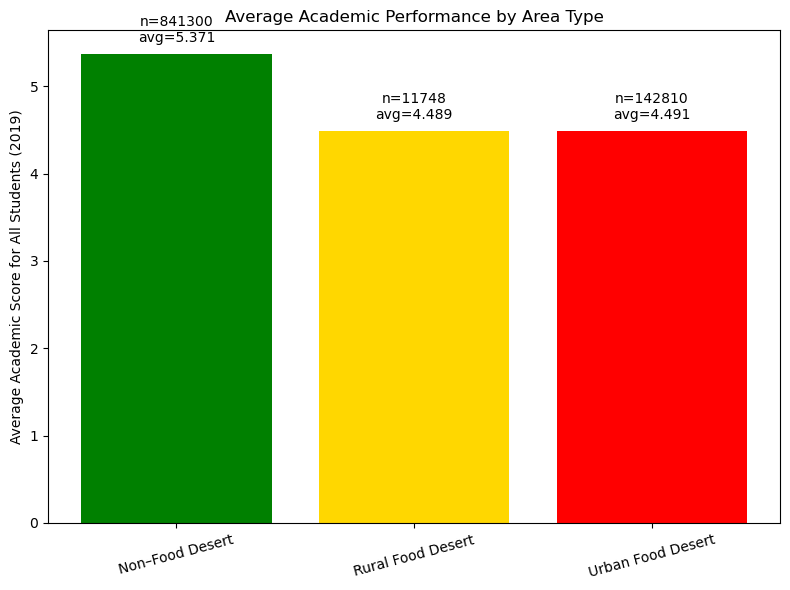

In [72]:
# ANALYSIS QUESTION 2: 
# Is there statistical significance if we look at only food deserts?

# Load the dataset
df = pd.read_csv("data/full_joined_table.csv")

# Drop missing values 
df = df.dropna(subset=['gcs_mn_all', 'PovertyRate'])

# Define food desert conditions
poverty = df['PovertyRate'] > 20
low_income = df['LowIncomeTracts'] == 1
urban_fd = (df['Urban'] == 1) & (df['LATracts_half'] == 1)
rural_fd = (df['Urban'] == 0) & (df['LATracts10'] == 1)

# Create area_type column
df['area_type'] = 'Non–Food Desert'
df.loc[poverty & low_income & urban_fd, 'area_type'] = 'Urban Food Desert'
df.loc[poverty & low_income & rural_fd, 'area_type'] = 'Rural Food Desert'

# Group by area type and compute mean and count
score_summary = df.groupby('area_type')['gcs_mn_all'].agg(['mean', 'count']).reset_index()
score_summary.columns = ['area_type', 'avg_score', 'num_entries']
print(score_summary)

# Define custom colors
color_map = {
    'Urban Food Desert': 'red',
    'Rural Food Desert': 'gold',
    'Non–Food Desert': 'green'
}
bar_colors = [color_map[area] for area in score_summary['area_type']]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(
    score_summary['area_type'],
    score_summary['avg_score'],
    color=bar_colors
)

# Add count labels on top of each bar
for bar, count, avg in zip(bars, score_summary['num_entries'], score_summary['avg_score']):
    height = bar.get_height()
    label = f'n={count}\navg={avg:.3f}'
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, label, ha='center', va='bottom')

# Labels and title
plt.ylabel('Average Academic Score for All Students (2019)')
plt.title('Average Academic Performance by Area Type')
plt.xticks(rotation=15)
plt.tight_layout()

plt.show()

In [ ]:
# Q2 Statistical Analysis: Perform a 1-sample t-test to compare the average 
# score in different area types to the overall mean score

# Calculate the overall mean score
overall_mean = df['gcs_mn_all'].mean()

# Calculate the mean and standard deviation of the Non-Food Desert group
non_food_desert_scores = df[df['area_type'] == 'Non–Food Desert']['gcs_mn_all']
non_food_desert_mean = non_food_desert_scores.mean()

# Define the food desert groups you want to compare
food_desert_groups = ['Urban Food Desert', 'Rural Food Desert']

# Run a 1-sample t-test for each food desert group against the Non-Food Desert group mean
def ttest_pairwise(df):
    for area in food_desert_groups:
        # Select the scores (gcs_mn_all) for counties with corresponding 
        # food desert type (e.g., Urban or Rural)
        food_desert_scores = df[df['area_type'] == area]['gcs_mn_all']
        
        # Perform the 1-sample t-test
        t_stat, p_value = stats.ttest_1samp(food_desert_scores, non_food_desert_mean)
        
        # Print results
        print(f"T-test for {area} vs Non–Food Desert:")
        print(f"  t-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")
        
        if p_value < 0.05:
            print(f"  ➤ Statistically significant difference from Non–Food Desert.")
        else:
            print(f"  ➤ No significant difference from Non–Food Desert.")
        print("-" * 40)

# Run the paired t-test comparisons
print("\n=== Paired T-Test Results ===")
ttest_pairwise(df)

    


=== Paired T-Test Results ===
T-test for Urban Food Desert vs Non–Food Desert:
  t-statistic = -37.416, p-value = 1.139e-296
  ➤ Statistically significant difference from Non–Food Desert.
----------------------------------------
T-test for Rural Food Desert vs Non–Food Desert:
  t-statistic = 0.206, p-value = 8.375e-01
  ➤ No significant difference from Non–Food Desert.
----------------------------------------
